<a href="https://colab.research.google.com/github/Tan-Yu/TensorFlow-Sandbox/blob/main/Project_2_Identifying_Flowers_in_tf_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use tf_flowers

## Loading Data
1. Import tf_flowers dataset
2. Assert into the tf.data.Dataset instance
3. Use the tfds.builder

In [15]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the dataset
(train_data, test_data), info= tfds.load('tf_flowers', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)
assert isinstance(train_data, tf.data.Dataset)
tfflowers_builder = tfds.builder('tf_flowers')


In [16]:
print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


## Resize Image
Note that the tf_flowers dataset already has labels so resizing need to put 2 parameters

In [14]:
resized_train_data = train_data.map(lambda image, label: (tf.image.resize(image, [224, 224]), label))
resized_test_data = test_data.map(lambda image, label: (tf.image.resize(image, [224, 224]), label))



## Normalize the Data



In [7]:
resized_train_data = resized_train_data.map(lambda x, y: (x/255, y))
resized_test_data = resized_test_data.map(lambda x, y: (x/255, y))


Cannot use batch["image"]. Need to use the index number of the column... (but why...?)

I think it's because after resizing it, the column names disappear? 



In [17]:
for batch in resized_train_data.batch(32):
    x_train = batch[0]
    y_train = batch[1].numpy().astype("uint8")
for batch in resized_test_data.batch(32):
    x_test = batch[0]
    y_test = batch[1].numpy().astype("uint8")

In [9]:


# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [19]:
# Train the model
model.fit(resized_train_data.batch(32), epochs=30, validation_data=resized_test_data.batch(32))



Epoch 1/30
92/92 [==============================] - 7s 51ms/step - loss: 1.3145 - accuracy: 0.4356 - val_loss: 1.1023 - val_accuracy: 0.5613
Epoch 2/30
92/92 [==============================] - 5s 59ms/step - loss: 1.0309 - accuracy: 0.5821 - val_loss: 0.9427 - val_accuracy: 0.6390
Epoch 3/30
92/92 [==============================] - 5s 51ms/step - loss: 0.8834 - accuracy: 0.6584 - val_loss: 0.8495 - val_accuracy: 0.6567
Epoch 4/30
92/92 [==============================] - 5s 52ms/step - loss: 0.7387 - accuracy: 0.7217 - val_loss: 0.8011 - val_accuracy: 0.6853
Epoch 5/30
92/92 [==============================] - 5s 58ms/step - loss: 0.6118 - accuracy: 0.7738 - val_loss: 0.8758 - val_accuracy: 0.6757
Epoch 6/30
92/92 [==============================] - 5s 55ms/step - loss: 0.4711 - accuracy: 0.8249 - val_loss: 0.9685 - val_accuracy: 0.6785
Epoch 7/30
92/92 [==============================] - 5s 57ms/step - loss: 0.4229 - accuracy: 0.8413 - val_loss: 1.1477 - val_accuracy: 0.6376
Epoch 8/30
92

In [20]:
# Evaluate the model
test_loss, test_acc = model.evaluate(resized_test_data.batch(32))
print('Test accuracy:', test_acc)


23/23 [==============================] - 1s 21ms/step - loss: 2.6455 - accuracy: 0.6785
Test accuracy: 0.6784741282463074


In [21]:
info.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

Test Image:


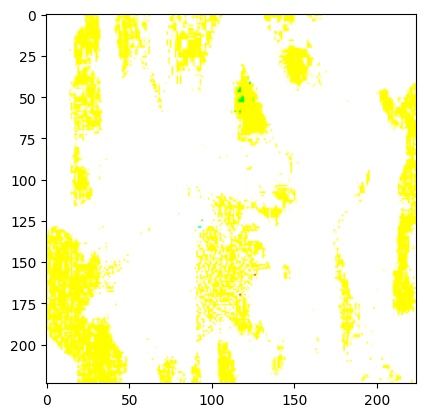

1/1 [==============================] - 0s 17ms/step
Prediction: dandelion with probability 75.45%


In [25]:
import numpy as np
import matplotlib. pyplot as plt
# Get a random test image
test_image = x_test[np.random.choice(x_test.shape[0], size=1, replace=False).item()]

# Print the test image
print("Test Image:")
plt.imshow(test_image)
plt.show()

# Make a prediction on the test image
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]

# Get the category name with the highest probability
category = info.features['label'].names[np.argmax(prediction)]

# Print the prediction
print("Prediction: {} with probability {:.2f}%".format(category, prediction.max()*100))


# Test 2

Putting the normalization and resizing step in the model

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
(train_data, test_data), info = tfds.load('tf_flowers', split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

resized_train_data = train_data.map(lambda image, label: (tf.image.resize(image, [224, 224]), label))
resized_test_data = test_data.map(lambda image, label: (tf.image.resize(image, [224, 224]), label))

# Normalize the data using a Rescaling layer in the model

# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(resized_train_data.batch(32), epochs=10, validation_data=resized_test_data.batch(32))

# Evaluate the model
test_loss, test_acc = model.evaluate(resized_test_data.batch(32))
print('Test accuracy:', test_acc)


Epoch 1/10
92/92 [==============================] - 9s 79ms/step - loss: 1.3487 - accuracy: 0.4196 - val_loss: 1.0877 - val_accuracy: 0.5436
Epoch 2/10
92/92 [==============================] - 5s 51ms/step - loss: 0.9827 - accuracy: 0.6035 - val_loss: 0.9356 - val_accuracy: 0.6335
Epoch 3/10
92/92 [==============================] - 6s 61ms/step - loss: 0.8469 - accuracy: 0.6781 - val_loss: 0.8615 - val_accuracy: 0.6676
Epoch 4/10
92/92 [==============================] - 5s 56ms/step - loss: 0.7112 - accuracy: 0.7381 - val_loss: 0.8302 - val_accuracy: 0.6839
Epoch 5/10
92/92 [==============================] - 6s 66ms/step - loss: 0.5577 - accuracy: 0.7950 - val_loss: 0.8964 - val_accuracy: 0.6853
Epoch 6/10
92/92 [==============================] - 5s 53ms/step - loss: 0.4210 - accuracy: 0.8505 - val_loss: 1.0244 - val_accuracy: 0.6839
Epoch 7/10
92/92 [==============================] - 5s 54ms/step - loss: 0.3716 - accuracy: 0.8655 - val_loss: 1.0614 - val_accuracy: 0.6785
Epoch 8/10
92